In [1]:
import argparse

parser = argparse.ArgumentParser(description='Training Script')
parser.add_argument('--name', type=str, default='dummy', help='Name of the experiment')
parser.add_argument('--method', type=str, default='deephit', help='whether to use mtlr or deephit')
parser.add_argument('--num_time_bins', type=int, default=12, help='NUmber of time bins')

# args = parser.parse_args()
args = parser.parse_args(args=[])

exp_name = args.name
method = args.method
num_time_bins = args.num_time_bins

In [2]:
import  pandas as pd
pd.read_csv('/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/TNM_hector_prompts.csv').columns

Index(['Unnamed: 0', 'PatientID', 'Gender', 'Age', 'Weight', 'Tobacco',
       'Alcohol', 'Performance status', 'HPV status (0=-, 1=+)', 'Surgery',
       'Chemotherapy', 'Relapse', 'RFS', 'TNM edition', 'T-stage', 'N-stage',
       'M-stage', 'TNM group', 'text', 'fold'],
      dtype='object')

In [3]:
from torch.utils.data import Dataset
import numpy as np
from pycox.models import CoxPH, MTLR, DeepHitSingle
from functools import partial

class Hector_Dataset_emb(Dataset):
    def __init__(self, emd_path, csv_file, args):
        self.emd = np.load(emd_path , allow_pickle=True).item()
        self.dataframe = pd.read_csv(csv_file)
        self.paths=[]
        self.args = args
        self.samples = self.prepare_samples()
        self.nii_to_tensor = partial(self.to_tensor)

    def prepare_samples(self):
        samples = []
        if self.args.method == 'mtlr':
            lbltrans = MTLR.label_transform(self.args.num_time_bins, scheme='quantiles')
        elif self.args.method == 'deephit':
            lbltrans = DeepHitSingle.label_transform(self.args.num_time_bins)
        y_bins, y_events = lbltrans.fit_transform(self.dataframe['RFS'].values, self.dataframe['Relapse'].values)
        
        for index, row in self.dataframe.iterrows():
            filename = row['PatientID'] + "_ct_roi.nii.gz"
            # filepath = os.path.join(self.data_folder, filename)
            image_embedding = self.emd[filename]['image_embedding']
            text_embedding = self.emd[filename]['text_embedding']
            fold = row['fold']
            gender = row['Gender']
            weight = row['Weight']
            samples.append((image_embedding, text_embedding, row['Relapse'], row['RFS'], filename, fold, gender, weight))
        samples = [tup + (val,) for tup, val in zip(samples, y_bins)]
        return samples

    def __len__(self):
        return len(self.samples)
    
    def train_val_split(self, fold):
        train_samples = []
        val_samples = []
        for sample in self.samples:
            if sample[5] == fold:
                val_samples.append(sample)
            else:
                train_samples.append(sample)
        return train_samples, val_samples

    def to_tensor(self, emb):
        # img_data = np.load(path)['arr_0']
        tensor = torch.tensor(emb)
        # tensor = tensor.unsqueeze(0)
        return tensor

    def __getitem__(self, index):
        image_embedding, text_embedding, relapse, RFS, filename, fold, gender, weight, y_bin= self.samples[index]
        text_embedding_tensor = self.to_tensor(text_embedding)
        image_embedding_tensor = self.to_tensor(image_embedding)
        return image_embedding_tensor, text_embedding_tensor, relapse, RFS, filename, fold, gender, weight, y_bin

hect_dataset = Hector_Dataset_emb(emd_path = '/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/embeddings/spatial_monai_again.npy',  
                csv_file ="/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/TNM_hector_prompts.csv", args=args)


In [4]:
from torch.utils.data import Dataset, DataLoader

dataloader = DataLoader(hect_dataset, batch_size=32, shuffle=True, num_workers=16)

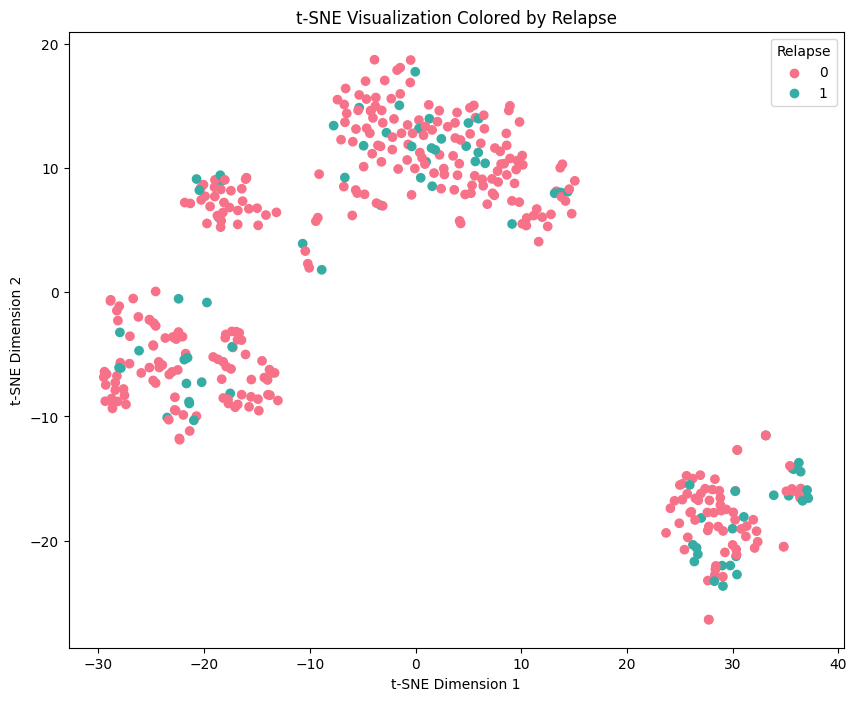

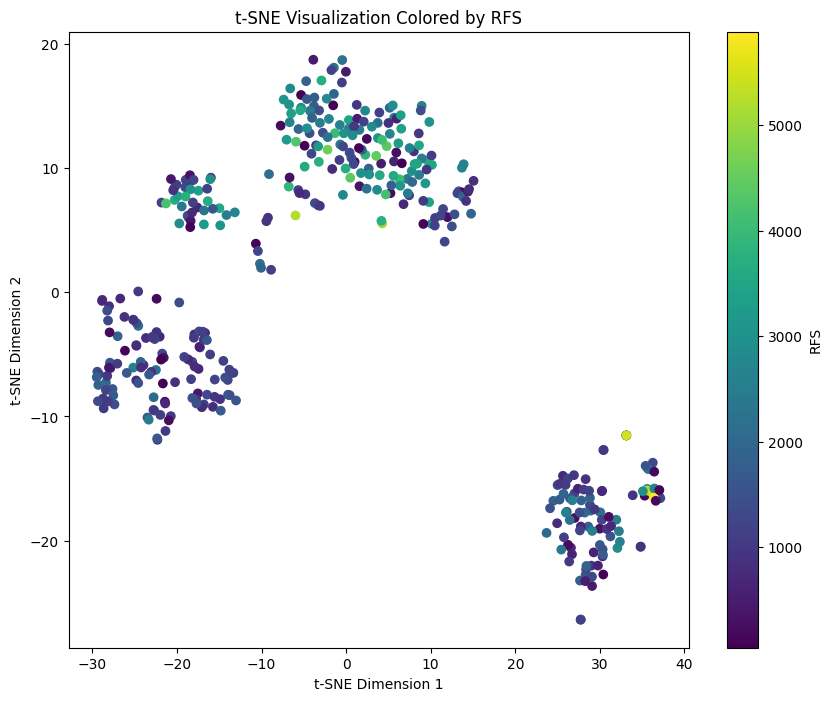

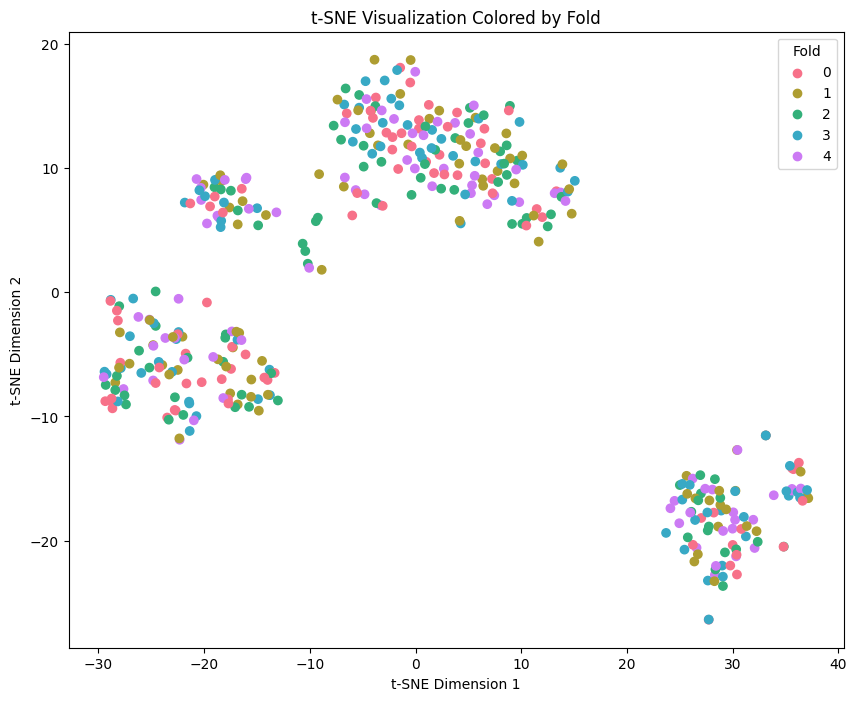

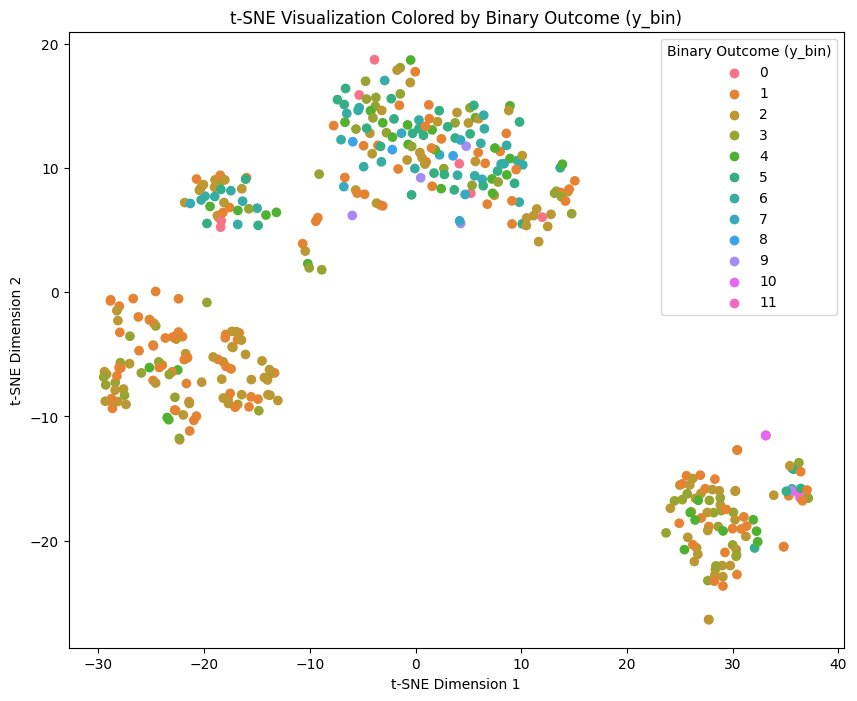

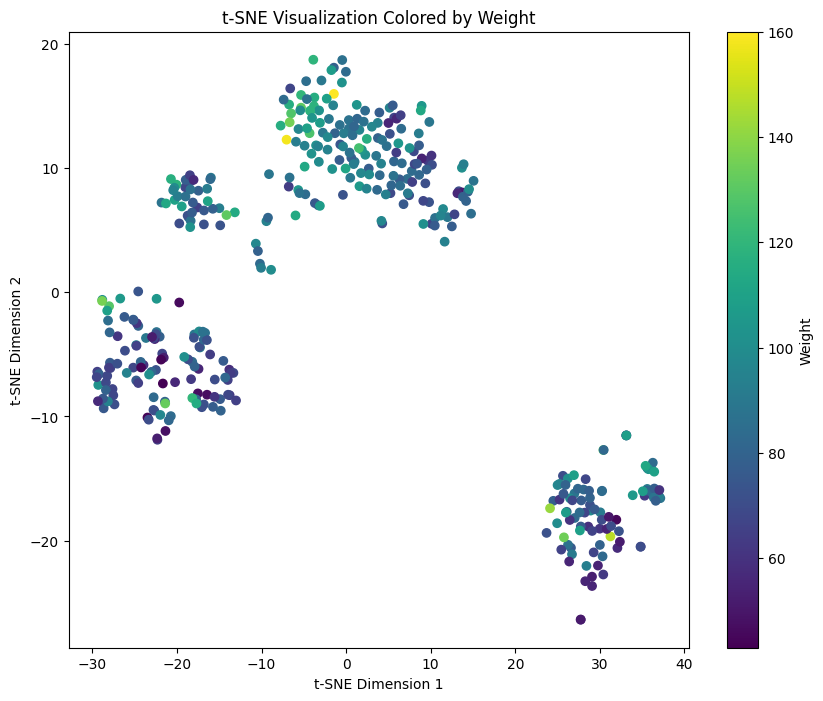

/tmp/ipykernel_2872807/1137243762.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=feature_name)


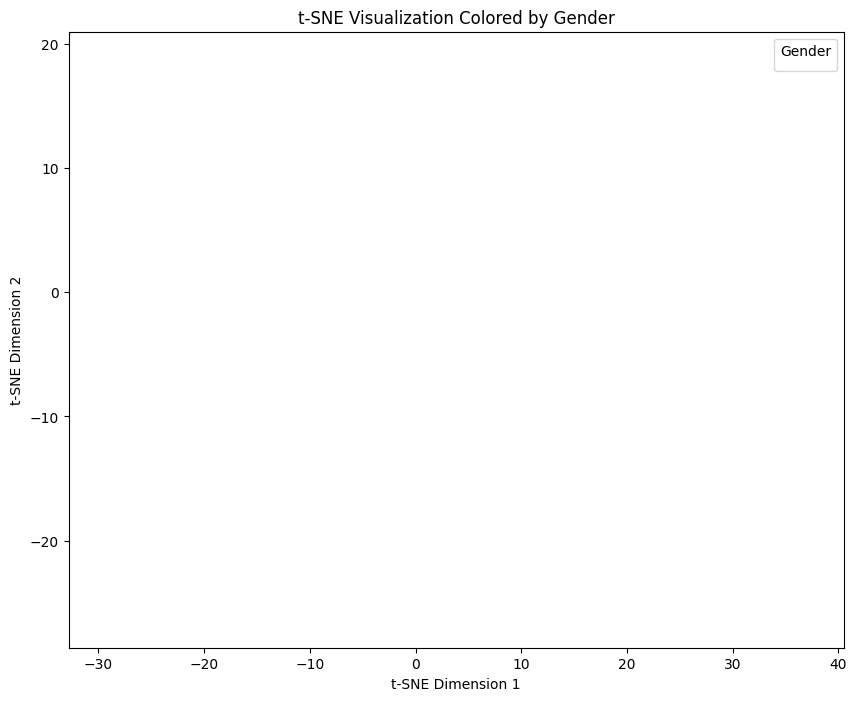

In [6]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming dataloader is defined and provides the mentioned outputs
embeddings = []
relapse_list = []
rfs_list = []
fold_list = []
y_bin_list = []
weight_list = []
gender_list = []

# Loop through the dataloader to collect data
for batch in dataloader:
    image_embedding, text_embedding, relapse, RFS, filename, fold, gender, weight, y_bin = batch
    
    # Combine image and text embeddings (concatenate along the last dimension)
    # combined_embedding = torch.cat((image_embedding, text_embedding), dim=1)  # Adjust dim if needed
    combined_embedding = image_embedding  # Adjust dim if needed
    
    embeddings.append(combined_embedding.cpu().numpy())
    relapse_list.extend(relapse.cpu().numpy())
    rfs_list.extend(RFS.cpu().numpy())
    fold_list.extend(fold.cpu().numpy())
    y_bin_list.extend(y_bin.cpu().numpy())
    weight_list.extend(weight.cpu().numpy())
    # gender_list.extend(gender.cpu().numpy())

# Convert embeddings to a 2D numpy array
embeddings = np.vstack(embeddings)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Function to plot based on a feature
def plot_tsne(feature_values, feature_name, is_categorical=True):
    plt.figure(figsize=(10, 8))
    
    if is_categorical:
        unique_values = np.unique(feature_values)
        palette = sns.color_palette("husl", len(unique_values))
        value_colors = {val: palette[i] for i, val in enumerate(unique_values)}
        colors = [value_colors[val] for val in feature_values]
        
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
        
        # Create dummy scatter for legend
        for val, color in value_colors.items():
            plt.scatter([], [], c=[color], label=str(val))
        plt.legend(title=feature_name)
        
    else:  # Continuous feature
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=feature_values, cmap="viridis")
        plt.colorbar(scatter, label=feature_name)
    
    plt.title(f"t-SNE Visualization Colored by {feature_name}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# Plot based on different features
plot_tsne(relapse_list, "Relapse", is_categorical=True)
plot_tsne(rfs_list, "RFS", is_categorical=False)
plot_tsne(fold_list, "Fold", is_categorical=True)
plot_tsne(y_bin_list, "Binary Outcome (y_bin)", is_categorical=True)
plot_tsne(weight_list, "Weight", is_categorical=False)
# plot_tsne(gender_list, "Gender", is_categorical=True)


In [20]:
import numpy as np
np.unique(bins, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([  3,  14,  18,  42, 121, 117,  81,   3,   8,   2]))

In [24]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np

embeddings_all = np.load("/share/sda/mohammadqazi/project/CTscan_prognosis_VLM-main/docs/embeddings/spatial_monai_again.npy", allow_pickle=True).item()

# Extract labels and embeddings
labels = list(embeddings_all.keys())  # Patient IDs
embeddings = np.array([embeddings_all[label]["image_embedding"] for label in labels])  # Image embeddings

tsne = TSNE(n_components=2, random_state=42) 
tsne_results = tsne.fit_transform(embeddings)


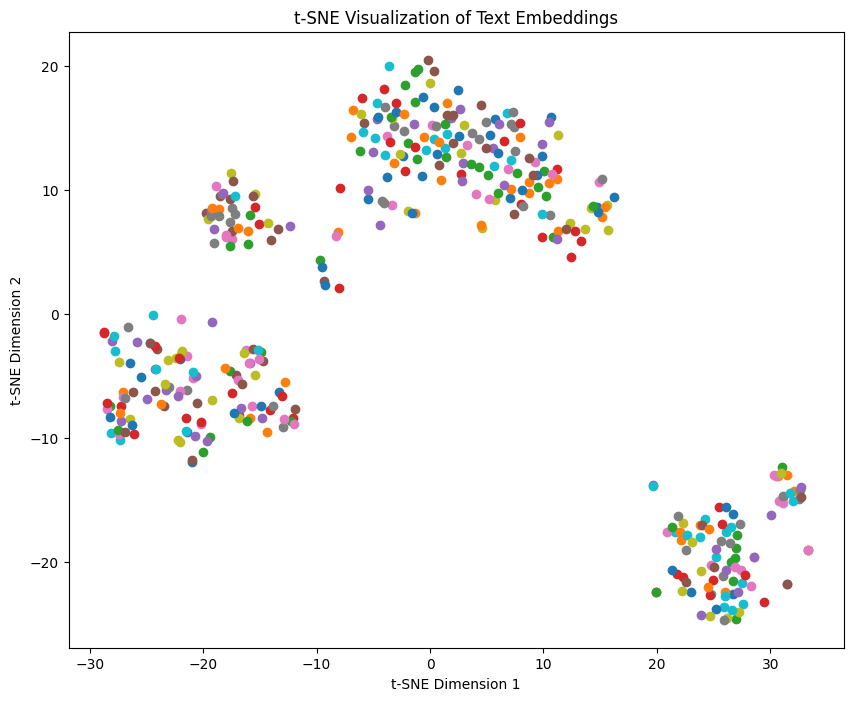

In [26]:
# Plot the t-SNE results
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    plt.scatter(tsne_results[i, 0], tsne_results[i, 1], label=label)

# Annotate points with labels
# for i, label in enumerate(labels):
#     plt.annotate(label, (tsne_results[i, 0], tsne_results[i, 1]))

plt.title("t-SNE Visualization of Text Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
# plt.legend()
plt.show()
# plt.savefig('tsne_both.png')